# Car Damage Detective

Our goal is to classify cars if they are damaged or not.

To achive this goal we need to perform a few steps which are :

1. Is the input picture actually a car or not?

2. Is the car damaged or not?

3. Which part of the car is damaged?

4. How much impact did the car take during its crash?

In [1]:
#Importing all used packages and libraries.
import pandas as pd
import numpy as np
import os
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from keras.preprocessing.image import load_img , img_to_array
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
#This is for ignoring output warnings.
warnings.simplefilter(action="ignore",category=FutureWarning)

In [2]:
#Creating different objects based on VGG and Resnet architecture.
#All of them were trained on the imagenet dataset.
model_vgg16 = VGG16(weights='imagenet')
model_vgg19 = VGG19(weights='imagenet')
model_resnet50 = ResNet50(weights='imagenet')

2022-02-11 14:11:40.110280: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


These models are already trained and can classify cars from other objects.(Multilabel Classification)

Lets double check the models and see if they can classify an image correctly.


Since our models expect 224 by 224 sized images we need to change the
size of our models.

In [3]:
#Resizing the given picture.
def prepare_image(image_path):
    image = load_img(image_path, target_size=(224, 224)) #Creates a PIL object.
    image = img_to_array(image) #Converting PIL image to a numpy array.
    image = np.expand_dims(image, axis=0) #Expanding the x-axis by one dimention.
    image = preprocess_input(image) #Encoding array.(Only works with imagenet)
    return image

In [4]:
processed_image = prepare_image("test.jpg") #Chose a random photo from google.
#Do we have the desired results?
processed_image.shape

(1, 224, 224, 3)

From left to right => Batchsize , X-dim , Y-dim , Channels(3 for RGB)

Classifing the new image with all our models and deciding which one to use for our webapp.
Since we used pretrained models we are confident that all of them are good enough, but lets double check everything.

In [5]:
#Using argmax to only save the classified label.(Class with the highest value)
prediction_vgg16 = np.argmax(model_vgg16.predict(processed_image))
prediction_vgg19 = np.argmax(model_vgg19.predict(processed_image))
prediction_resnet50 = np.argmax(model_resnet50.predict(processed_image))

What will the result be?

The prediction for each photo will be an array of float numbers which are the percentage of probability of a class.

In [6]:
model_vgg16.predict(processed_image).shape

(1, 1000)

Results of all our models :

In [7]:
print("VGG16 Prediction : ",prediction_vgg16)
print("VGG19 Prediction : ",prediction_vgg19)
print("Resnet50 Prediction : ",prediction_resnet50)

VGG16 Prediction :  717
VGG19 Prediction :  751
Resnet50 Prediction :  717


All models did the classification right(somehow).

The VGG19 model predicted our SUV as a race car.

The test instance is techniqually a car but not the correct class.

From now on we just use the VGG16 model because its lighter than the other two 
and performs good enough.

Labels can be checked here :

https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/

We have chosen our model for classifying the cars.

Now we need a model to classify the damaged cars from the intact cars.

Its not a good idea to train a model from scratch in this step.So we expand the chosen model with new layers for training.

In [8]:
#Lets take a quick look at our model
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

We need to change some upper layers.

So we can answer the second question : Is the car damaged or not?

Now we need to get new training data to train our model for damaged cars.

I used the car damage detection dataset from kaggle made by "Anuj Shah".

https://www.kaggle.com/anujms/car-damage-detection

(Dataset is stored in repository)

In [9]:
#defining the base, train and validation directory path
base_dir = '/Users/ardalan/GitHub/car-damage-detection/data1a'
train_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'validation')
#defining the damage and whole , train nand validation directory
train_damage_dir = os.path.join(train_dir, '00-damage')
train_whole_dir = os.path.join(train_dir, '01-whole')
validation_damage_dir = os.path.join(validation_dir, '00-damage')
validation_whole_dir = os.path.join(validation_dir, '01-whole')

Before feeding the model with our new data we need to scale the inputs and rescale the photos(in pixels).

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
#Since we are performing binary classification the class mode should be "binary".
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(224, 224), 
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


Our dataset is quite small...

Its better to use more training samples but since we are using pre-trained layers it's not a big deal.

(To be honest, I coudln't find a better dataset)

Now its time to train our model.

In [12]:
#Creating a checkpoint in case that anything goes wrong.
#I dont have a gpu so it's fairly possible.
#Saving checkpoint in repository.
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("/Users/ardalan/GitHub/car-damage-detection/model_checkpoint.h5",
                                                monitor = "val_loss",
                                                verbose = 1,
                                                save_best_only = True,
                                                save_freq = "epoch")

In [13]:
#We don't want our model to overfit,so we need early stopping.
model_earlystopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                        patience = 5, #How many epochs should it wait to stop the training?
                                                        restore_best_weights = True) #If this hyperparameter is true you dont need to give a new file path.
                                                        #It will save the best model weights in the model checkpoint callback.(above)

In [14]:
#Creating the new model based on our VGG model.
base_model = VGG16(input_shape = (224, 224, 3),  include_top = False, weights = 'imagenet') #Using depth=3 for RGB

In [15]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

The pretrained layers are ready,we need to add a flatten layer for reshaping the inputs of new layers to 1D
and after that dense layers to train on the new data.

In [16]:
#Adding new layers to our base model.
new_model = tf.keras.Sequential() #Creating an object from scratch.
for layer in base_model.layers[:]: #Freezing all pre-trained layers.
    layer.trainable = False
new_model.add(base_model) #Adding our base model to the new model.
new_model.add(layers.Flatten()) #The last output(this layers input) has to be flattend : x*y*filters=dimention
new_model.add(layers.Dense(512,activation="elu")) #To avoid overfitting we are gonna use "elu" instead of "relu"
#We are performing binary classification,which means one perceptron with "sigmoid" activation function.
new_model.add(layers.Dense(1,activation="sigmoid"))
#Lets check the new model:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 27,560,769
Trainable params: 12,846,081
Non-trainable params: 14,714,688
_________________________________________________________________


Everything seems ok.

Lets compile the new DNN and start the training process.

In [17]:
#Compiling the new model.
optimizer = keras.optimizers.RMSprop(learning_rate=0.005) #Its better to use adaptive gradient descent instead of normal GD.
new_model.compile(loss='binary_crossentropy', #Loss function for binary classification is always binary_crossentropy.
              optimizer=optimizer,
              metrics=['Accuracy','Precision','Recall']) #Using different evaluation metrics.

In [18]:
##Starting the training process.
model_callbacks = [model_checkpoint,model_earlystopping] #These are the callbacks we made above.
history = new_model.fit(train_generator, #Training the model.
                      epochs = 10, #It wont use all epochs since we made earlystopping object.
                      validation_data = validation_generator,
                      callbacks=model_callbacks) 

Epoch 1/10
92/92 [==============================] - ETA: 0s - loss: 7.1995 - Accuracy: 0.6962 - precision: 0.6981 - recall: 0.6913
Epoch 1: val_loss improved from inf to 0.29610, saving model to /Users/ardalan/GitHub/car-damage-detective/model_checkpoint.h5
92/92 [==============================] - 385s 4s/step - loss: 7.1995 - Accuracy: 0.6962 - precision: 0.6981 - recall: 0.6913 - val_loss: 0.2961 - val_Accuracy: 0.9000 - val_precision: 0.9107 - val_recall: 0.8870
Epoch 2/10
92/92 [==============================] - ETA: 0s - loss: 0.7887 - Accuracy: 0.7973 - precision: 0.7925 - recall: 0.8054
Epoch 2: val_loss did not improve from 0.29610
92/92 [==============================] - 348s 4s/step - loss: 0.7887 - Accuracy: 0.7973 - precision: 0.7925 - recall: 0.8054 - val_loss: 0.4117 - val_Accuracy: 0.8565 - val_precision: 0.9767 - val_recall: 0.7304
Epoch 3/10
92/92 [==============================] - ETA: 0s - loss: 0.5435 - Accuracy: 0.8332 - precision: 0.8314 - recall: 0.8359
Epoch 3: 

ATTENTION!!

The wright path would be training the model, evaluating it on the test set and comparing it to the validation set.

Since theres not enough data I will use the trained model without evaluation.

This model is not meant to be deployed so its ok to perform next steps.

(The goal is to show how to perform such a task)

The last step would be saving our trained model.

We will use this trained model in a separate app.py file.

After saving the model there won't be a need for using this notebook again.

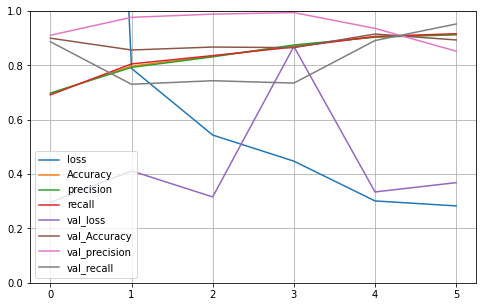

In [19]:
#Plotting train and validation.
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [21]:
#Saving model for app.
#Naming our model "detective"
new_model.save("detective.h5")